# GW170817 Progenitor Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=3)
import pandas as pd
import scipy as sp

import astropy.constants as C
import astropy.units as u

from matplotlib import gridspec
import matplotlib
from matplotlib import ticker
%matplotlib inline

from scipy.stats import maxwell
from scipy.stats import uniform
from scipy.stats import powerlaw
from scipy.interpolate import interp1d
from scipy.integrate import quad

import brewer2mpl
# brewer2mpl.get_map args: set name  set type  number of colors
bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
colors = bmap.mpl_colors

 
CB_colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

### Read in data from a particular input sampling

In [46]:
run = 'mkfafm'
df = pd.read_csv('runs/planck_h0/outfile_'+run+'.dat')

# Add systemic velocities
from progenitor.plot_vsys import Plot
suptitle='Flat in $A_{pre}$,Flat in $M_{He}$, Maxwellian Kick'
P=Plot('pe_samps/TidalP-1.dat', 'NGC', 2.0, 2.8, 'ESO',suptitle, output='runs/planck_h0/outfile_'+run)
V_sys = P.getV_sys()
df['Vsys'] = V_sys

# remove binaries with T_delay > 14 Gyr
df = df[df['flag'] != 2]

# Now that NaNs are gone, change certain quantities to numeric
df.loc[:,'vphi'] = pd.to_numeric(df['vphi'])
df.loc[:,'vcosth'] = pd.to_numeric(df['vcosth'])
df.loc[:,'Rmerge'] = pd.to_numeric(df['Rmerge'])
df.loc[:,'Rmerge_proj'] = pd.to_numeric(df['Rmerge_proj'])
df.loc[:,'Vfinal'] = pd.to_numeric(df['Vfinal'])

44.0942414005


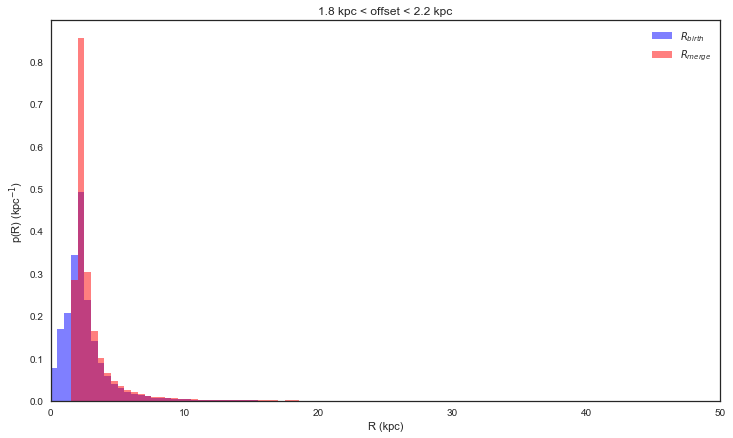

In [19]:
fig = plt.figure(figsize=(12,7))
sns.set_style("white")

gs = gridspec.GridSpec(5,5)

ax_plot = fig.add_subplot(gs[:,:])

_,_,_ = ax_plot.hist(df_temp['R'], bins=100, color='b', alpha=0.5, normed=True, range=(0,50), label='$R_{birth}$')
_,_,_ = ax_plot.hist(df_temp['Rmerge'], bins=100, color='r', alpha=0.5, normed=True, range=(0,50), label='$R_{merge}$')
ax_plot.set_xlabel('R (kpc)')
ax_plot.set_ylabel('p(R) (kpc$^{-1}$)')
ax_plot.set_xlim(0,50)

ax_plot.set_title('1.8 kpc < offset < 2.2 kpc')

plt.legend(loc='upper right')

In [47]:
df_temp = df[df.Tmerge>1]

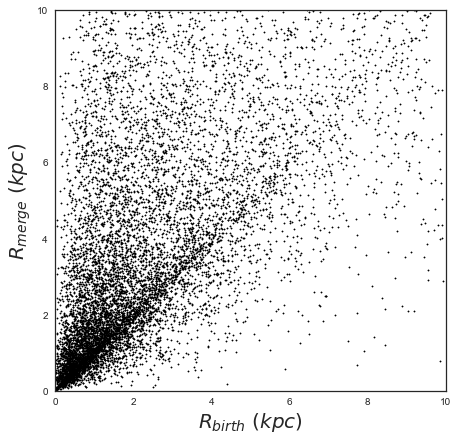

In [48]:
fig = plt.figure(figsize=(7,7))
sns.set_style("white")

gs = gridspec.GridSpec(5,5)

ax = fig.add_subplot(gs[:,:])

x = df_temp.R[:20000]
y = df_temp.Rmerge[:20000]

ax.scatter(x, y, s=2, color='k')
ax.set_xlim(0,10)
ax.set_ylim(0,10)

ax.set_xlabel('$R_{birth}\ (kpc)$', fontsize=20)
ax.set_ylabel('$R_{merge}\ (kpc)$', fontsize=20)

### Figure 1

In [5]:
# set constants and values for NGC4993
h = 0.678
G = 6.67*10**-11
Mhalo = (10**12.2)/h * u.Msun.to(u.kg)
Mbulge = (10**10.454)/h**2 * u.Msun.to(u.kg)
Re = 2.8 * u.kpc.to(u.m)
abulge = Re/1.8153
rho_crit = 1.879 * h**2 * 10**(-26)

def c_200(M_200):
    return 10**(0.76 - 0.1*np.log10(M_200 / ((2e12/h) * C.M_sun.value)))

c = c_200(Mhalo)
R_200 = (3*Mhalo / (800*np.pi*rho_crit))**(1./3)
Rs = R_200 / c
rho0 = Mhalo / (4*np.pi*Rs**3 * (np.log(1+c) - c/(1+c)))


# define useful functions
def rho_star(r):
    return Mbulge/(2*np.pi) * (abulge/r) * (1/(r+abulge)**3)
def rho_dm(r):
    return rho0 / ((r/Rs)*(1+(r/Rs))**2)
def phi_star(r):
    return -G*Mbulge / (r+abulge)
def phi_dm(r):
    return -4*np.pi*G*rho0*Rs**3 / r * np.log(1+(r/Rs))
def v_esc(r):
    return np.sqrt(2*G*(4./3*np.pi*r**3*(rho_star(r)+rho_dm(r))) / r)
def integrate_dm_mass(r):
    return 4*np.pi*r**2 * rho_dm(r)
def integrate_star_mass(r):
    return 4*np.pi*r**2 * rho_star(r)

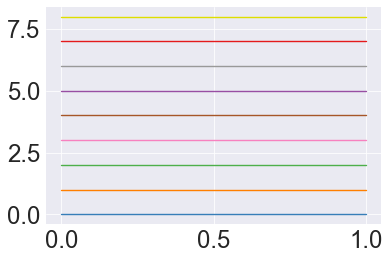

In [6]:
x=np.linspace(0,1,100)
for i, c in enumerate(CB_colors):
    plt.plot(x,i*np.ones(100),color=c)

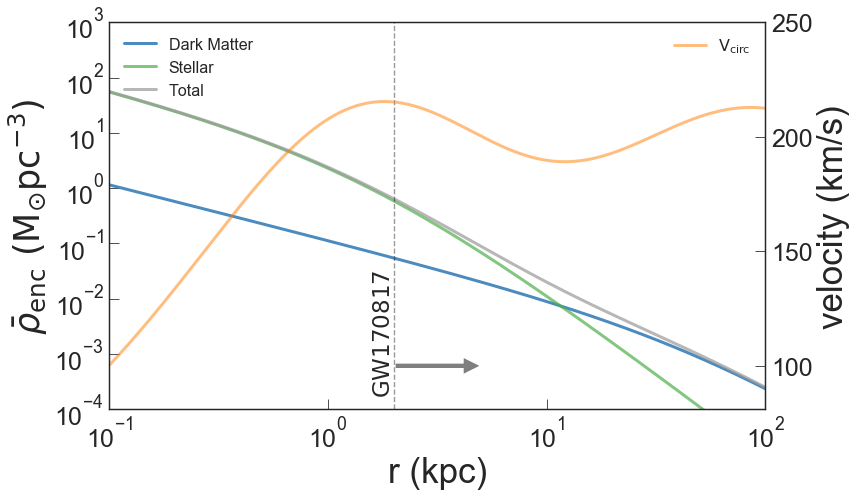

In [7]:
# plot the density profile and velocity profile as function of R

fig = plt.figure(figsize=(12,7))
sns.set_style("white")

gs = gridspec.GridSpec(5,5)

ax_plot = fig.add_subplot(gs[:,:])


opt = dict(color='k', 
            arrowstyle = 'simple,head_width=.75,head_length=.75',
            connectionstyle = 'arc3,rad=0', alpha=0.5)


rsamp = np.logspace(-1,2,10000) * u.kpc.to(u.m)
# create interpolator functions
M_dm = []
M_star = []
for r in rsamp:
    M_dm.append(quad(integrate_dm_mass, 0.0, r)[0])
    M_star.append(quad(integrate_star_mass, 0.0, r)[0])
M_dm = np.asarray(M_dm)
M_star = np.asarray(M_star)
f_halo = interp1d(rsamp,M_dm)
f_bulge = interp1d(rsamp,M_star)

def v_circ(r,M):
    return np.sqrt(G*M/r)

vcirc=[]
for r in rsamp:
    vcirc.append(v_circ(r, (f_halo(r)+f_bulge(r))))
vcirc = np.asarray(vcirc)


# density ax
'''ax_plot.plot(rsamp*u.m.to(u.kpc), rho_dm(rsamp)*u.kg.to(u.Msun)/(u.m.to(u.pc)**3), color=CB_colors[0], label='Dark Matter', lw=3, alpha=0.9)
ax_plot.plot(rsamp*u.m.to(u.kpc), rho_star(rsamp)*u.kg.to(u.Msun)/(u.m.to(u.pc)**3), color=CB_colors[2], label='Stellar', lw=3, alpha=0.7)
ax_plot.plot(rsamp*u.m.to(u.kpc), rho_dm(rsamp)*u.kg.to(u.Msun)/(u.m.to(u.pc)**3)+\
            rho_star(rsamp)*u.kg.to(u.Msun)/(u.m.to(u.pc)**3), color=CB_colors[6], label='Total', lw=3, alpha=0.7)'''
rhostar_enc = (M_star*u.kg.to(u.Msun)/(4./3*np.pi*(rsamp*u.m.to(u.pc))**3))
rhodm_enc = (M_dm*u.kg.to(u.Msun)/(4./3*np.pi*(rsamp*u.m.to(u.pc))**3))
rhocomb_enc = rhostar_enc+rhodm_enc
ax_plot.plot(rsamp*u.m.to(u.kpc), rhodm_enc, color=CB_colors[0], label='Dark Matter', lw=3, alpha=0.9)
ax_plot.plot(rsamp*u.m.to(u.kpc), rhostar_enc, color=CB_colors[2], label='Stellar', lw=3, alpha=0.7)
ax_plot.plot(rsamp*u.m.to(u.kpc), rhocomb_enc, color=CB_colors[6], label='Total', lw=3, alpha=0.7)
ax_plot.set_xscale('log')
ax_plot.set_yscale('log')
ax_plot.set_ylabel(r'$\bar{\rho}_{\mathrm{enc}}\ \mathrm{(M_{\odot} pc^{-3})}$', fontsize=35)
ax_plot.axvline(2.0, color='k', linestyle='--', alpha=0.4)
ax_plot.set_xlim(0.1,100)
ax_plot.set_ylim(1e-4,1e3)
ax_plot.set_xlabel('r (kpc)', fontsize=35)
ax_plot.legend(loc='upper left', fontsize='large', prop={'size': 16})
ax_plot.tick_params(labelsize=25, axis=u'both', which='major', direction='in', length=10)





# velocity ax
ax_cp = ax_plot.twinx()
ax_cp.plot(rsamp*u.m.to(u.kpc), vcirc*u.m.to(u.km), color=CB_colors[1], label=r'$\mathrm{V}_{\mathrm{circ}}$', lw=3, alpha=0.5)
ax_cp.set_ylabel('velocity (km/s)', fontsize=35)
ax_cp.set_xlim(0.1,100)
ax_cp.set_ylim(81,250)
ax_cp.set_yticks([100,150,200,250])
ax_cp.legend(loc='upper right', fontsize='large', prop={'size': 16})
ax_cp.tick_params(labelsize=25, axis=u'both', which='major', direction='in', length=10)

ax_cp.annotate('$\mathrm{GW}170817$', (1.6, 135), fontsize=23, rotation=90)
ax_cp.annotate('',xy=(5,100),xycoords='data',xytext =(2.0,100),textcoords = 'data',arrowprops=opt,size=20)



plt.tight_layout()
plt.savefig('gal_props.pdf', format='pdf', dpi=500)


In [8]:
rsamp = np.logspace(-1,2,10000) * u.kpc.to(u.m)
comb = rho_dm(rsamp)*u.kg.to(u.Msun)/(u.m.to(u.pc)**3)+rho_star(rsamp)*u.kg.to(u.Msun)/(u.m.to(u.pc)**3)
stellar = rho_star(rsamp)*u.kg.to(u.Msun)/(u.m.to(u.pc)**3)

In [45]:
r=2.0
np.where(rsamp*u.m.to(u.kpc)<r)

(array([   0,    1,    2, ..., 4334, 4335, 4336]),)

In [46]:
(rhostar_enc[4336]*4./3 * np.pi * (r*u.kpc.to(u.pc))**3)/1e9

19.733636768056037

### Figure 2

In [13]:
# cut full dataframe to match the bounds for the systems being scatterplotted below
MC_points = df[(df['Rmerge']>1.8) & (df['R']<2.2)]

# set paths to the different Vkick radial and tangential grids
stm='output_runs_tangential'
tang_paths = [stm+'32_2.dat', stm+'452.dat', stm+'152.dat', stm+'32_18.dat', stm+'32_22.dat']
#tang_paths = ['tan_cos0/output_runs_tangential.dat']


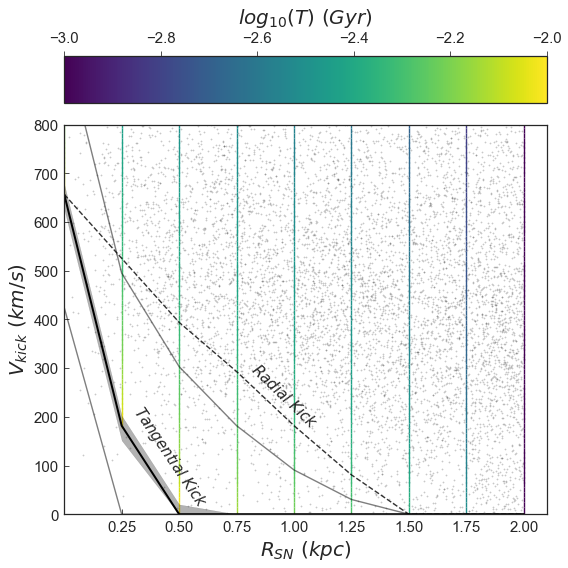

In [44]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(7,7)

sns.set_style("white")

ax1_plot = fig.add_subplot(gs[1:,:7])
ax1_cbar = fig.add_subplot(gs[0,:7])

# plot the radial limits for MHe=3, Apre=2
df_rad = pd.read_csv('vkick_lims/radial/output_runs_radial32_2.dat')

# scatterplot post-SN points in the background
ax1_plot.scatter(MC_points['R'][:10000], MC_points['Vkick'][:10000], color='k', s=2, alpha=0.2, rasterized=True)

# find the minimum for each sampled value of R
rad_mins=[]
for r in np.unique(df_rad['R']):
    temp = df_rad[df_rad['R']==r]
    rad_mins.append(temp['Vkick'].min())
rad_mins = np.asarray(rad_mins)

ax1_plot.plot(np.unique(df_rad['R']), rad_mins, color='k', linestyle='--', alpha=0.8)


# Run through all the paths specified above to draw limit lines
for idx, tpath in enumerate(tang_paths):

    # read files
    df_tang = pd.read_csv('vkick_lims/tangential/'+tpath)


    # for binaries that merge too quick fo anything to register
    for i in xrange(len(df_tang)):
        if df_tang['Tmerge'].iloc[i]<1e-5:
            df_tang['Tmerge'].iloc[i]=1e-5

    # plot Tmerge points for the first set of MHe/Apre only
    if idx == 0:
        pts = ax1_plot.scatter(df_tang['R'], df_tang['Vkick'], marker="|", c=np.log10(df_tang['Tmerge']), \
                          vmin=-3, vmax=-2, s=30, cmap='viridis', label=None, rasterized=True)
        
    # find the mins for each unique R
    tang_mins=[]
    for r in np.unique(df_tang['R']):
        temp = df_tang[df_tang['R']==r]
        tang_mins.append(temp['Vkick'].min())
    tang_mins = np.asarray(tang_mins)

    if idx==0:
        ax1_plot.plot(np.unique(df_tang['R']), tang_mins, color='k', lw=2)
    if idx==1 or idx==2:
        ax1_plot.plot(np.unique(df_tang['R']), tang_mins, color='k', alpha=0.5)
    if idx==3:
        lower = np.append(tang_mins,[0])
    if idx==4: 
        upper = tang_mins
        ax1_plot.fill_between(np.unique(df_tang['R']), lower, upper, color='k', alpha=0.3)


# add colorbar
cbar = fig.colorbar(pts, ticks=None, cax=ax1_cbar, orientation='horizontal')
cbar.set_label('$log_{10}(T)\ (Gyr)$', fontsize=20, labelpad=8)
cbar.ax.tick_params(labelsize=15, axis=u'both', which='major', direction='out', length=5)

ax1_cbar.xaxis.tick_top()
ax1_cbar.xaxis.set_label_position('top') 

ax1_plot.set_xlabel(r'$R_{SN}\ (kpc)$', fontsize=20)
ax1_plot.set_ylabel(r'$V_{kick}\ (km/s)$', fontsize=20)
ax1_plot.set_xlim(0,2.1)
ax1_plot.set_ylim(0.1,800)
ax1_plot.set_xticks(np.linspace(0.25,2,8))
ax1_plot.tick_params(labelsize=15, axis=u'both', which='major', direction='in', length=5)


plt.tight_layout()

ax1_plot.annotate('$Tangential\ Kick$', (0.28,200), rotation=-56, fontsize=15)
ax1_plot.annotate('$Radial\ Kick$', (0.8,290), rotation=-44, fontsize=15)

plt.savefig('vkick_limits.pdf', format='pdf', dpi=300)



In [15]:
# Find percentage of points that lie below the line

MC_points = df[(df['Rmerge']>1.8) & (df['R']<2.0)]
df_tang = pd.read_csv('vkick_lims/tangential/output_runs_tangential452.dat')
Rs = np.unique(df_tang['R'])
Rs[0] = 0


tang_mins=[]
for r in np.unique(df_tang['R']):
    temp = df_tang[df_tang['R']==r]
    tang_mins.append(temp['Vkick'].min())
tang_mins = np.asarray(tang_mins)

f = interp1d(Rs,tang_mins)

MC_points['R'], MC_points['Vkick']

below = 100.*np.sum(f(MC_points['R']) > MC_points['Vkick']) / len(MC_points)

print run
print '   Percent of points below line: %.2f%%\n' % below

fkfafm
   Percent of points below line: 0.03%



### Figure 3

This figure is created in the main astro-traj code using the Plot class. Saved trajectories need to be called. 

### Figure 4

In [16]:
# define sampling functions
def vkick_uniform(samps):
    return uniform.pdf(samps, 0, 2500)

def vkick_hobbs(samps):
    return maxwell.pdf(samps, loc=0, scale=265)

def vkick_beniamini(samps, vk0, vk_sig=np.arcsinh(0.5)):
    return 1 / (np.sqrt(2*np.pi)*vk_sig*samps) * np.exp(-(np.log(samps/vk0)**2)/(2*vk_sig**2))
    

def deltaM_beniamini(samps, M0, M_sig=np.arcsinh(0.5)):
    return 1 / (np.sqrt(2*np.pi)*M_sig*samps) * np.exp(-(np.log(samps/M0)**2)/(2*M_sig**2))

def mhe_uniform(samps):
    return uniform.pdf(samps, 1, 8)


def apre_uniform(samps):
    return uniform.pdf(samps, 0, 10)

def apre_log(samps):
    return 10**uniform.pdf(samps, np.log10(0.1), np.log10(10))


def r_hernquist(samps):
    # Note that the radial distance from the center has no effect on whether or not the binary survives the SN, 
    # so that the R values in the full dataframe should mirror the distribution
    size = len(samps)
    x, bins = np.histogram(df.R.sample(1000), bins = 50)
    # center bins
    bins = (bins[:-1] + bins[1:]) / 2
    bins[0], bins[-1] = df['R'].min(), df['R'].max()
    f = interp1d(x,bins)
    return f(samps)


# dictionaries for plotting         
lim_dict={'Vkick': (0,1000), 'Vsys': (0,1000), 'Mhe': (df['Mns'].min(),8), 'Apre': (0.1,10), 'Apost': (0.1), \
          'Apre_Apost': (0.5,2), 'R': (0.1,10), 'R_proj': (0,10), 'Rmerge': (2.2,10), 'Tmerge': (0,14)}

lbl_dict={'Vkick': '$V_{kick}\ (km\ s^{-1})$', 'R': '$R_{SN}\ (kpc)$', 'R_proj': '$R_{SN,proj}\ (kpc)$', \
          'Mhe': '$M_{He}\ (M_{\odot})$', 'Apre': '$A_{pre}\ (R_{\odot})$', 'Apost': '$A_{post}\ (R_{\odot})$', \
          'Apre_Apost': '$A_{pre}/A_{post}$', 'Tmerge': '$T_{delay}\ (Gyr)$', \
          'Rmerge': '$R_{merge}\ (kpc)$',  'Rmerge_proj': '$R_{merge,proj}\ (kpc)$', 'Vsys': '$V_{sys}\ (km/s)$'}

samp_dict={'Vkick': vkick_uniform, \
            'Mhe': mhe_uniform, \
            'Apre': apre_uniform, 
            #'R' : r_hernquist
          }
         

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


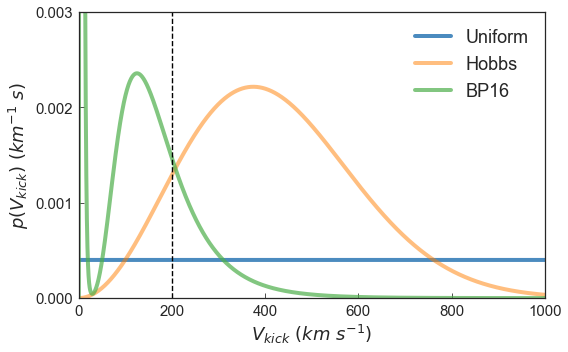

In [17]:
fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(4,4, wspace=0.1, hspace=0.1, bottom=0.2)
ss = 10000

ax = fig.add_subplot(gs[0:4,0:4])

samps = np.linspace(lim_dict['Vkick'][0], lim_dict['Vkick'][1], ss)

# plot flat kicks
ax.plot(samps, vkick_uniform(samps), color=CB_colors[0], lw=4, label='Uniform', alpha=0.9)

# plot hobbs kicks
ax.plot(samps, vkick_hobbs(samps), color=CB_colors[1], lw=4, label='Hobbs', alpha=0.5)

# plot beniamini kicks
pop_1 = 0.6*vkick_beniamini(samps, 5)
pop_2 = 0.4*vkick_beniamini(samps, 158)
ax.plot(samps, pop_1+pop_2, color=CB_colors[2], lw=4, label='BP16', alpha=0.7)

ax.set_xlim(0,1000)
ax.set_ylim(0,0.003)
ax.set_xlabel(lbl_dict['Vkick'], fontsize=18)
ax.set_ylabel('$p(V_{kick})\ (km^{-1}\ s)$', fontsize=18)
ax.set_yticks([0,1e-3,2e-3,3e-3])
#ax.set_yticks([])
ax.legend(loc='upper right', prop={'size': 18})

ax.axvline(200, color='k', linestyle='--')

ax.tick_params(labelsize=15, axis='both', which='major', direction='in', length=5)

gs.tight_layout(fig)
plt.savefig('kick_dist.pdf', format='pdf', dpi=300)

### Figure 5

In [18]:
def pdf_1d_v2(x_str, df, times, offsets, kde=False, Trange=False, save=False):
    
    sns.set_style("white")
    fig = plt.figure(figsize=(10,4.5))
    
    gs = gridspec.GridSpec(12,20, wspace=0.1, hspace=0.1)

    ax11 = fig.add_subplot(gs[0:4,0:4])
    ax12 = fig.add_subplot(gs[0:4,4:8])
    ax13 = fig.add_subplot(gs[0:4,8:12])
    ax14 = fig.add_subplot(gs[0:4,12:16])
    ax21 = fig.add_subplot(gs[4:8,0:4])
    ax22 = fig.add_subplot(gs[4:8,4:8])
    ax23 = fig.add_subplot(gs[4:8,8:12])
    ax24 = fig.add_subplot(gs[4:8,12:16])
    ax31 = fig.add_subplot(gs[8:12,0:4])
    ax32 = fig.add_subplot(gs[8:12,4:8])
    ax33 = fig.add_subplot(gs[8:12,8:12])
    ax34 = fig.add_subplot(gs[8:12,12:16])
    axs=[[ax11,ax12,ax13,ax14],[ax21,ax22,ax23,ax24],[ax31,ax32,ax33,ax34]]

    ax1_cbar = fig.add_subplot(gs[1:4,16])
    ax2_cbar = fig.add_subplot(gs[4:8,16:])
    ax3_cbar = fig.add_subplot(gs[9:12,16])
    
    # Set colormap
    Tmin, Tmax = 0, np.log10(np.asarray(times).max())
    Omin, Omax = np.log10(np.asarray(offsets).min()), np.log10(np.asarray(offsets).max())
    
    cm = plt.get_cmap('viridis')
    cNorm_times  = matplotlib.colors.Normalize(vmin=Tmin, vmax=Tmax)
    scalarMap_times = matplotlib.cm.ScalarMappable(norm=cNorm_times, cmap=cm)
    cNorm_offsets  = matplotlib.colors.Normalize(vmin=Omin, vmax=Omax)
    scalarMap_offsets = matplotlib.cm.ScalarMappable(norm=cNorm_offsets, cmap=cm)
    
    for p, param in enumerate(x_str):
        if param == 'Vkick':
            ticks = [0,250,500,750,1000]
        if param == 'Vsys':
            ticks = [0,250,500,750,1000]
        elif param == 'Mhe':
            ticks = [2.5,5,7.5]
        elif param == 'Apre':
            ticks = [2.5,5,7.5,10]
        elif param == 'R':
            ticks = [2.5,5,7.5,10]
        print param
        
        minor_ticks = np.arange(lim_dict[param][0], lim_dict[param][1], 5) 
        
        
        # ax 1: alter time constraints
        ax = axs[0][p]
        ax.get_yaxis().set_ticks([])
        ax.set_xlim(lim_dict[param])
        ax.tick_params(labelsize=10, axis='x', which='major', direction='in', length=5)
        ax.set_xticks(ticks)
        ax.xaxis.tick_top()
        
        if p==0:
            ax.set_ylabel('Varying\nDelay Times', fontsize=13, rotation=0, labelpad=55, verticalalignment='center')
        
        # plot input distributions
        ss=10000
        # FIXME
        if param in samp_dict.keys():
            samps = np.linspace(lim_dict[param][0], lim_dict[param][1], ss)
            ax.fill_between(samps, y1=0, y2=samp_dict[param](samps), color='k', lw=1, alpha=0.5, label=None)
        if param == 'R':
            sns.kdeplot(data=df[param][:10000], ax=ax, gridsize=1000, color='k', lw=1, shade=True, alpha=0.5, label=None)
            
        for t in times:
            if t != 0: colorVal = scalarMap_times.to_rgba(np.log10(t))
            else: colorVal = scalarMap_times.to_rgba(0)
            if Trange==True:
                succ_temp = df[(df['Tmerge'] > t-dt) & (df['Tmerge'] < t+dt) & (df.Rmerge_proj < 2.2) & (df.Rmerge_proj > 1.8)]
            else:
                succ_temp = df[(df['Tmerge'] > t) & (df.Rmerge_proj < 2.2) & (df.Rmerge_proj > 1.8)]
                
            
            bn=int(np.sqrt(len(succ_temp)))
            _, _, _ = ax.hist(succ_temp[param], color=colorVal, normed=True, histtype='step', bins=bn, alpha=0.3, label=None)
            if kde:
                sns.kdeplot(data=succ_temp[param], ax=ax, gridsize=1000, color=colorVal, lw=2, label=None)
        ax.legend_.remove()
                
        ys = ax.set_ylim()
        ax.set_ylim(0,ys[1])
        
        
        
        
        
        # time constraints for bottom two rows
        ts=(1.0,14.0)
        
        # ax 2: standard plot against SN
        ax = axs[1][p]
        ax.set_xlim(lim_dict[param])
        ax.tick_params(labelsize=13)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if p==0:
            ax.set_ylabel('Post-SN and\nGW170817-like\nSystems', fontsize=13, rotation=0, labelpad=55, verticalalignment='center')
            

        
        succ_temp = df[(df.Tmerge>ts[0]) & (df.Tmerge<ts[1]) & (df.flag==1)]
        # downsample SN survivors
        SN_temp = df[(df.Tmerge>ts[0]) & (df.Tmerge<ts[1])][:len(succ_temp)]

        bn=int(np.sqrt(len(succ_temp)))
        #_, _, _ = ax.hist(SN_temp[param], color='r', normed=True, histtype='stepfilled', bins=bn, alpha=0.3, label=None)
        if param=='R':
            _, _, _ = ax.hist(succ_temp[param], color='g', normed=True, histtype='stepfilled', bins=1000, alpha=0.3, label=None)
        else:
            _, _, _ = ax.hist(succ_temp[param], color='g', normed=True, histtype='stepfilled', bins=bn, alpha=0.3, label=None)
        if kde:
            if param == 'R':
                sns.kdeplot(data=SN_temp[param], ax=ax, gridsize=1000, clip=(0,100), color='r', lw=2, label='SN')
            else:
                sns.kdeplot(data=SN_temp[param], ax=ax, gridsize=1000, clip=lim_dict[param], color='r', lw=2, label='SN')
            sns.kdeplot(data=succ_temp[param], ax=ax, gridsize=1000, color='g', lw=2, label='Analog', alpha=0.5)
            ax.legend_.remove()
        
        ss=10000
        if param in samp_dict.keys():
            samps = np.linspace(lim_dict[param][0], lim_dict[param][1], ss)
            ax.fill_between(samps, y1=0, y2=samp_dict[param](samps), color='k', lw=1, alpha=0.5, label=None)
        if param == 'R':
            sns.kdeplot(data=df[param][:10000], ax=ax, gridsize=1000, clip=(0,100), color='k', lw=1, shade=True, alpha=0.5, label='Sampled')
            ax.legend_.remove()
            
            
        ys = ax.set_ylim()
        ax.set_ylim(0,ys[1])
        
  
        
        
        # ax 3: alter offset constraints
        ax = axs[2][p]
        ax.get_yaxis().set_ticks([])
        ax.set_xlim(lim_dict[param])
        ax.tick_params(labelsize=10, axis='x', which='major', direction='in', length=5)
        ax.set_xticks(ticks)
        
        ax.set_xlabel(lbl_dict[param], fontsize=13)

        if p==0:
            ax.set_ylabel('Varying\nOffsets', fontsize=13, rotation=0, labelpad=55, verticalalignment='center')
        ss=10000
        if param in samp_dict.keys():
            samps = np.linspace(lim_dict[param][0], lim_dict[param][1], ss)
            ax.fill_between(samps, y1=0, y2=samp_dict[param](samps), color='k', lw=1, alpha=0.5, label=None)
        if param == 'R':
            sns.kdeplot(data=df[param][:1000], ax=ax, gridsize=1000, color='k', lw=1, shade=True, alpha=0.5, label=None)
            ax.legend_.remove()
            
        
        for off in offsets:
            colorVal = scalarMap_offsets.to_rgba(np.log10(off))
            
            succ_temp = df[(df['Rmerge_proj'] > off-dx) & (df['Rmerge_proj'] < off+dx) \
                           & (df['Tmerge'] > ts[0]) & (df['Tmerge'] < ts[1])]

            bn=int(np.sqrt(len(succ_temp)))
            _, _, _ = ax.hist(succ_temp[param], color=colorVal, normed=True, histtype='step', bins=bn, alpha=0.3, label=None)
            if kde:
                sns.kdeplot(data=succ_temp[param], ax=ax, gridsize=1000, color=colorVal, lw=2, label=None)
                ax.legend_.remove()
                
        ys = ax.set_ylim()
        ax.set_ylim(0,ys[1])
        

        
        
    # times colorbar axes
    pts = ax.scatter([0],[0],c=[0], vmin=np.asarray(times).min(), vmax=np.asarray(times).max(), cmap='viridis', s=0.01, alpha=1)
    cbar = fig.colorbar(pts, cax=ax1_cbar, orientation='vertical', \
                        ticks=[np.asarray(times).min(),np.asarray(times).max()])    
    cbar.set_label(r'$T_{delay}\ (Gyr)$', fontsize=13, labelpad=8)
    
    tick_locator = ticker.MaxNLocator(nbins=6)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=10, axis=u'both', which='major', direction='out', length=5)
    
    
    # SN legend axes
    ax2_cbar.set_xlim(0,1)
    ax2_cbar.set_ylim(0,1)
    ax2_cbar.plot([-1],[-1], color='k', alpha=0.5, linewidth=10, label='Input')
    ax2_cbar.plot([-1],[-1], color='r', alpha=1, linewidth=2, label='Post-SN')
    ax2_cbar.plot([-1],[-1], color='g', alpha=0.5, linewidth=2, label='GW170817-like')
    ax2_cbar.set_xticks([])
    ax2_cbar.set_yticks([])
    ax2_cbar.axis('off')

    ax2_cbar.legend(loc='center', prop={'size': 9}, frameon=False, bbox_to_anchor=(0.4, 0.5))

    
    # offset colorbar axes
    pts = ax.scatter([0],[0],c=[0], vmin=0, vmax=np.asarray(offsets).max(), cmap='viridis', s=0.01, alpha=1)
    cbar = fig.colorbar(pts, cax=ax3_cbar, orientation='vertical', \
                        ticks=[np.asarray(offsets).min(),np.asarray(offsets).max()])    
    cbar.set_label(r'$R_{offset}\ (kpc)$', fontsize=13, labelpad=8)
    
    tick_locator = ticker.MaxNLocator(nbins=4)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=10, axis=u'both', which='major', direction='out', length=5)
                
    plt.subplots_adjust(left=0.14, bottom=0.12, right=1.02, top=0.92)
    if save:
        plt.savefig('constraints.pdf', format='pdf', dpi=300)
        

Vkick
Mhe
Apre
R


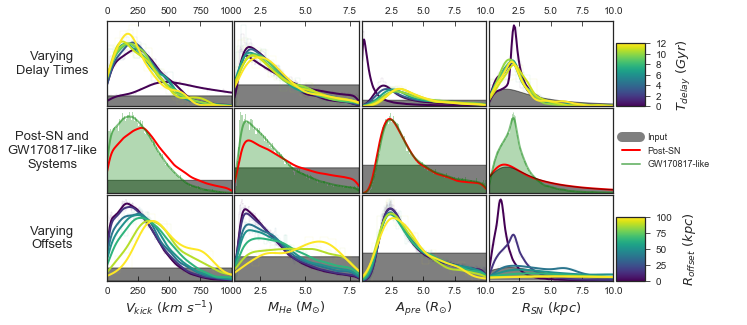

In [19]:
times = [0,1,2,4,6,8,10,12]
dt=0.1
x = 2.0; dx=0.2
offsets = [0.5*x, x, 3*x, 5*x, 10*x, 30*x, 50*x]
params=['Vkick', 'Mhe', 'Apre', 'R']
pdf_1d_v2(params, df, times=times, offsets=offsets, kde=True, Trange=True, save=True)

In [20]:
def pdf_1d_ss(x_str, df, times, offsets, kde=False, Trange=False, save=False):
    
    sns.set_style("white")
    fig = plt.figure(figsize=(4,12))
    
    gs = gridspec.GridSpec(4,1, wspace=0.1, hspace=0.35)

    ax11 = fig.add_subplot(gs[0:1,:])
    ax12 = fig.add_subplot(gs[1:2,:])
    ax13 = fig.add_subplot(gs[2:3,:])
    ax14 = fig.add_subplot(gs[3:4,:])
    axs=[ax11,ax12,ax13,ax14]

    
    for p, param in enumerate(x_str):
        if param == 'Vkick':
            ticks = [0,250,500,750,1000]
        elif param == 'Mhe':
            ticks = [0,2.5,5,7.5]
        elif param == 'Apre':
            ticks = [0,2.5,5,7.5,10]
        elif param == 'R':
            ticks = [0,2.5,5,7.5,10]
        print param
        
        minor_ticks = np.arange(lim_dict[param][0], lim_dict[param][1], 5) 
        

        
        # time constraints for bottom two rows
        ts=(1.0,14.0)
        
        # ax 2: standard plot against SN
        ax = axs[p]
        ax.set_xlim(lim_dict[param])
        ax.tick_params(labelsize=15)
        ax.get_yaxis().set_ticks([])
        ax.set_xlabel(lbl_dict[param], fontsize=18)
        
        if p==0:
            ax.set_title('Post-SN and\nGW170817-like\nSystems', fontsize=20)
            

        
        succ_temp = df[(df.Tmerge>ts[0]) & (df.Tmerge<ts[1]) & (df.flag==1)]
        # downsample SN survivors
        SN_temp = df[(df.Tmerge>ts[0]) & (df.Tmerge<ts[1])][:len(succ_temp)]

        bn=int(np.sqrt(len(succ_temp)))
        #_, _, _ = ax.hist(SN_temp[param], color='r', normed=True, histtype='stepfilled', bins=bn, alpha=0.3, label=None)
        if param=='R':
            _, _, _ = ax.hist(succ_temp[param], color='g', normed=True, histtype='stepfilled', bins=1000, alpha=0.3, label=None)
        else:
            _, _, _ = ax.hist(succ_temp[param], color='g', normed=True, histtype='stepfilled', bins=bn, alpha=0.3, label=None)
        if kde:
            if param == 'R':
                sns.kdeplot(data=SN_temp[param], ax=ax, gridsize=1000, clip=(0,100), color='r', lw=2, label='Post-SN')
            else:
                sns.kdeplot(data=SN_temp[param], ax=ax, gridsize=1000, clip=lim_dict[param], color='r', lw=2, label='Post-SN')
            sns.kdeplot(data=succ_temp[param], ax=ax, gridsize=1000, color='g', lw=2, label='GW170817-like')
            ax.legend_.remove()
        
        ss=10000
        if param in samp_dict.keys():
            samps = np.linspace(lim_dict[param][0], lim_dict[param][1], ss)
            ax.fill_between(samps, y1=0, y2=samp_dict[param](samps), color='k', lw=1, alpha=0.5, label=None)
        if param == 'R':
            sns.kdeplot(data=df[param][:10000], ax=ax, gridsize=1000, clip=(0,100), color='k', lw=1, shade=True, alpha=0.5, label='Sampled')
            
            
        ax.get_xaxis().set_ticks(ticks)
        if param=='Mhe':
            ax.set_xlim(lim_dict[param])
        ys = ax.set_ylim()
        ax.set_ylim(0,ys[1])
        
        if p==3:
            ax.legend(loc='upper right', prop={'size': 14})

    
    
    '''# SN legend axes
    ax2_cbar.set_xlim(0,1)
    ax2_cbar.set_ylim(0,1)
    ax2_cbar.plot([-1],[-1], color='k', alpha=0.5, linewidth=10, label='Input')
    ax2_cbar.plot([-1],[-1], color='r', alpha=1, linewidth=2, label='Post-SN')
    ax2_cbar.plot([-1],[-1], color='g', alpha=1, linewidth=2, label='GW170817-like')
    ax2_cbar.set_xticks([])
    ax2_cbar.set_yticks([])
    ax2_cbar.axis('off')

    ax2_cbar.legend(loc='center', prop={'size': 18}, frameon=False, bbox_to_anchor=(0.4, 0.5))
    
    
    tick_locator = ticker.MaxNLocator(nbins=4)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=10)'''
                
    #plt.subplots_adjust(left=0.14, bottom=0.1, right=1.02, top=0.92)
    if save:
        plt.savefig('constraints_ss.pdf', format='pdf', dpi=300)

Vkick
Mhe
Apre
R


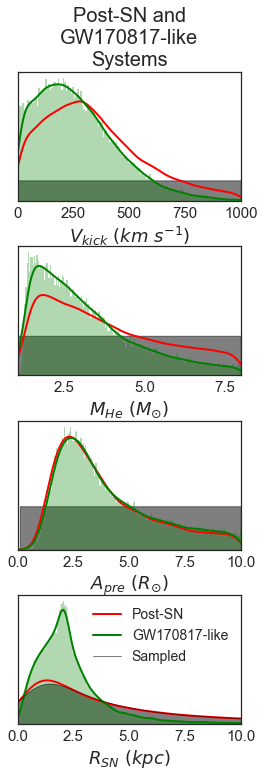

In [21]:
times = [0,1,2,4,6,8,10,12]
dt=0.1
x = 2.0; dx=0.2
offsets = [0.5*x, x, 3*x, 5*x, 10*x, 30*x, 50*x]
params=['Vkick', 'Mhe', 'Apre', 'R']
pdf_1d_ss(params, df, times=times, offsets=offsets, kde=True, Trange=True, save=True)

### Figure 6

In [ ]:
# read in data files for different samplings

vk_hobbs = pd.read_csv('current_runs/planck_h0/outfile_mkfafm.dat', usecols=['flag', 'Vkick', 'Apre', 'Mhe', 'R', 'Tmerge'])

vk_flat = pd.read_csv('current_runs/planck_h0/outfile_fkfafm.dat', usecols=['flag', 'Vkick', 'Apre', 'Mhe', 'R', 'Tmerge'])

vk_ben = pd.read_csv('current_runs/planck_h0/outfile_bkfabm.dat', usecols=['flag', 'Vkick', 'Apre', 'Mhe', 'R', 'Tmerge'])

In [ ]:
lim_dict={'Vkick': (0,1000), 'Mhe': (1,8), 'Apre': (0.1,10), 'Apost': (0.1), \
          'Apre_Apost': (0.5,2), 'R': (0.1,10), 'R_proj': (0,10), 'Rmerge': (2.2,10), 'Tmerge': (0,14)}

In [ ]:
def comp_kicks(dfs, xs, vary_param, vals, save=False):
    fig = plt.figure(figsize=(10,6))
    gs = gridspec.GridSpec(8,16, wspace=0.1, hspace=0.1)
    ss = 10000
    
    ax11 = fig.add_subplot(gs[0:4,0:4])
    ax12 = fig.add_subplot(gs[0:4,4:8])
    ax13 = fig.add_subplot(gs[0:4,8:12])
    ax14 = fig.add_subplot(gs[0:4,12:16])
    ax21 = fig.add_subplot(gs[4:8,0:4])
    ax22 = fig.add_subplot(gs[4:8,4:8])
    ax23 = fig.add_subplot(gs[4:8,8:12])
    ax24 = fig.add_subplot(gs[4:8,12:16])
    
    axs_rows = [[ax11,ax12,ax13,ax14],[ax21,ax22,ax23,ax24]]
        
    for t, axs in zip(vals,axs_rows):
        
        for x, ax in zip(xs,axs):
            # cut dataframes based on time constraints
            SN=False
            flat_succ = dfs[0][(dfs[0]['flag']==1) & (dfs[0][vary_param]>t)]
            hobbs_succ = dfs[1][(dfs[1]['flag']==1) & (dfs[1][vary_param]>t)]
            ben_succ = dfs[2][(dfs[2]['flag']==1) & (dfs[2][vary_param]>t)]
            if SN:
                flat_SN = dfs[0][(dfs[0][vary_param]>t)][:len(flat_succ)]
                hobbs_SN = dfs[1][(dfs[1][vary_param]>t)][:len(hobbs_succ)]
                ben_SN = dfs[2][(dfs[2][vary_param]>t)][:len(ben_succ)]
                                  
            samps = np.linspace(lim_dict[x][0], lim_dict[x][1], ss)
            
            # plot sampled distributions != Vkick
            samps = np.linspace(lim_dict[x][0], lim_dict[x][1], ss)
            if x=='Mhe':
                ax.plot(samps, samp_dict[x](samps), color='k', linestyle='--', alpha=0.4, lw=2)
            if x=='Apre':
                ax.plot(samps, samp_dict[x](samps), color='k', linestyle='--', alpha=0.4, lw=2)
            if x=='R':
                SNs = dfs[0][(dfs[0][vary_param]>t)][:ss]
                sns.kdeplot(data=SNs['R'], ax=ax, gridsize=1000, color='k', linestyle='--', alpha=0.4, lw=2, label='_nolegend_')

            # plot flat kicks
            bn = int(np.sqrt(len(flat_succ)))
            ax.hist(flat_succ[x], bins=bn, color=CB_colors[0], normed=True, histtype='stepfilled', lw=1, alpha=0.3, label=None)
            sns.kdeplot(data=flat_succ[x], ax=ax, gridsize=1000, color=CB_colors[0], lw=2, label='Uniform', alpha=0.9)
            if x=='Vkick':
                ax.plot(samps, vkick_uniform(samps), color=CB_colors[0], lw=2, alpha=0.9, linestyle='--', label=None)

            # plot hobbs kicks
            bn = int(np.sqrt(len(hobbs_succ)))
            ax.hist(hobbs_succ[x], bins=bn, color=CB_colors[1], normed=True, histtype='stepfilled', lw=1, alpha=0.3, label=None)
            sns.kdeplot(data=hobbs_succ[x], ax=ax, gridsize=1000, color=CB_colors[1], lw=2, label='Hobbs', alpha=0.5)
            samps = np.linspace(lim_dict[x][0], lim_dict[x][1], ss)
            if x=='Vkick':
                ax.plot(samps, vkick_hobbs(samps), color=CB_colors[1], lw=2, alpha=0.5, linestyle='--', label=None)

            # plot beniamini kicks
            bn = int(np.sqrt(len(ben_succ)))
            ax.hist(ben_succ[x], bins=1000, color=colors[2], normed=True, histtype='stepfilled', lw=0.2, alpha=0.3, label=None)
            sns.kdeplot(data=ben_succ[x], ax=ax, gridsize=1000, color=CB_colors[2], lw=2, label='BP16', alpha=0.7)

            # plot combination of low and high kicks from beniamini
            if x=='Vkick':
                samps = np.linspace(0,1000,1000)
                ax.hist(vk_ben[x], range=(0,1000), bins = int(np.sqrt(len(vk_ben))), \
                        histtype='step', color=CB_colors[2], lw=2, normed=True, alpha=0.7, linestyle='--', label=None)

                
            # plot combination of low and high deltaM from beniamini
            if x=='Mhe':
                samps = np.linspace(0,7,1000)
                ax.hist(vk_ben[x], range=(lim_dict[x][0],lim_dict[x][1]), bins = int(np.sqrt(len(vk_ben))), \
                        histtype='step', color=CB_colors[2], lw=2, normed=True, alpha=0.7, linestyle='--', label=None)

            
            # remove legend
            ax.legend_.remove()
            
            # set up limits and labels
            ax.set_xlim(lim_dict[x])
            if x=='Vkick':
                ax.set_ylim(0,0.005)
                #ax.set_xlim(0,250)
            ax.set_yticks([])
            if x == 'Vkick':
                ax.set_ylabel('$T_{delay} > %i\ Gyr$' % t, fontsize=18)
            
            # ticks
            if x == 'Vkick':
                ticks = [0,250,500,750,1000]
            elif x == 'Mhe':
                ticks = [2.5,5,7.5]
            elif x == 'Apre':
                ticks = [2.5,5,7.5,10]
            elif x == 'R':
                ticks = [2.5,5,7.5,10]
               
            if t==0:
                ax.set_xticks(ticks)
                ax.tick_params(axis='x', which='major', direction='in', length=5)
                ax.xaxis.set_ticklabels([])
            if t!=0:
                ax.set_xticks(ticks)
                ax.tick_params(labelsize=15, axis='x', which='major', direction='in', length=5)
                ax.set_xlabel(lbl_dict[x], fontsize=18)


                
            if t==0 and x=='R':
                ax.legend(loc='upper right', prop={'size': 14})
                
    plt.subplots_adjust(left=0.05 , bottom=0.1, right=0.96, top=0.98)
    if save:
        plt.savefig('kick_comparison.pdf', format='pdf', dpi=300)


In [ ]:
comp_kicks([vk_flat,vk_hobbs,vk_ben], ['Vkick','Mhe','Apre','R'], 'Tmerge', [0,1], save=True)

### Figure 7

In [41]:
# define RLO functions

def getRhe(Mhe):
    if Mhe<=2.5:
        return 3.0965-(2.013*np.log10(Mhe))
    else:
        return 0.0557*((np.log10(Mhe)-0.172)**-2.5)
    
def getRL(Mhe,M2,Apre,epre):

    exp1=1.0/3.0
    exp2=2.0/3.0
    q=Mhe/M2
    M=Mhe+M2 
    alpha=Apre
    ex=epre                         

    RL = (alpha*(1-ex)*0.49*(q**exp2))/((0.6*(q**exp2))+np.log(1.+(q**exp1)))
    return RL

def cutRLO(Mhe,M2,Apre):
    Mhe = np.asarray(Mhe)
    epre=np.full(Mhe.shape,0.0)
    Rhe = np.array([getRhe(Mhe[i]) for i in range(len(Mhe))])
    RL = getRL(Mhe, M2, Apre, epre)
    return np.where(RL<Rhe)[0], np.where(RL>Rhe)[0]   # format: RLO, nonRLO

In [42]:
# definte function for plotting successful and unsuccessful binaries
def joint_pdf_v2(df, x_str, y_str, ts, save=False, kde=False, RLO_flag=False, vkick_flag=False):

    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(11,11)
    ax_joint = fig.add_subplot(gs[3:,:-3])
    ax_marg_x = fig.add_subplot(gs[:3,:-3])
    ax_marg_y = fig.add_subplot(gs[3:,-3:])
    ax_legend = fig.add_subplot(gs[:3,-3:])
    if vkick_flag:
        ax_cbar = fig.add_subplot(gs[-2:,:-3])
    
    # sampling size for input distribution
    ss=10000
    
    # split dataframe into success and post-SN binaries
    if len(ts)==1:
        # lower limit
        succ = df[(df.Tmerge > ts[0]) & (df.flag == 1)]
        SN = df[(df.Tmerge > ts[0])] # downsample
    elif len(ts)==2:
        # bounded
        succ = df[(df.Tmerge > ts[0]) & (df.Tmerge < ts[1]) & (df.flag == 1)]
        SN = df[(df.Tmerge > ts[0]) & (df.Tmerge < ts[1])] # downsample
        
    bn = int(np.sqrt(len(succ)))

        
    # plot contour and scatter for successful binaries
    if RLO_flag:
        #sns.kdeplot(succ[x_str], succ[y_str], shade=False, ax=ax_joint, color='g', label=None)
        RLO, nonRLO = cutRLO(succ['Mhe'],succ['M2'],succ['Apre'])
        print 'RLO binaries: %.2f%%' % (100.*float(len(RLO))/float(len(succ)))
        ax_joint.scatter(succ[x_str].iloc[RLO], succ[y_str].iloc[RLO], c=CB_colors[2], s=4, label=None, marker='o', alpha=0.7, rasterized=True)
        ax_joint.scatter(succ[x_str].iloc[nonRLO], succ[y_str].iloc[nonRLO], c=CB_colors[0], s=4, label=None, marker='o', alpha=0.9, rasterized=True)
    elif vkick_flag:
        #sns.kdeplot(succ[x_str], succ[y_str], shade=False, ax=ax_joint, color='g', label=None)
        colpts = ax_joint.scatter(succ[x_str], succ[y_str], c=succ['Vkick'], vmin=100, \
                                  vmax=700, s=10, cmap='viridis', label=None)
        cbar = fig.colorbar(colpts, ticks=None, cax=ax_cbar, orientation='horizontal')
        ax_cbar.get_xaxis().set_ticks([])
        ax_cbar.get_yaxis().set_ticks([])
    else:
        if kde:
            sns.kdeplot(succ[x_str], succ[y_str], shade=True, ax=ax_joint, color='g', label=None)
        ax_joint.scatter(succ[x_str], succ[y_str], c='k', s=0.1, label=None)
    # label
    ax_joint.set_xlim(lim_dict[x_str])
    ax_joint.set_ylim(lim_dict[y_str])
    ax_joint.set_xlabel(lbl_dict[x_str])
    ax_joint.set_ylabel(lbl_dict[y_str])
    ax_joint.tick_params(labelsize=20, axis='both', which='major', direction='in', length=5)

    
    
    # plot marginalized pdfs  
    
    # x data
    ax_marg_x.tick_params(axis='x', which='major', direction='in', length=5)
    ax_marg_x.xaxis.set_ticklabels([])
    ax_marg_x.get_yaxis().set_ticks([])
    ax_marg_x.set_xlim(lim_dict[x_str])
    if RLO_flag:
        _, _, _ = ax_marg_x.hist(succ[x_str].iloc[nonRLO], color=CB_colors[0], normed=True, histtype='stepfilled', bins=bn, range=lim_dict[x_str], alpha=0.4, label=None)
        _, _, _ = ax_marg_x.hist(succ[x_str].iloc[RLO], color=CB_colors[2], normed=True, histtype='stepfilled', bins=bn, range=lim_dict[x_str], alpha=0.2, label=None)
        if kde:
            sns.kdeplot(data=succ[x_str].iloc[nonRLO], ax=ax_marg_x, gridsize=1000, color=CB_colors[0], lw=2, alpha=0.9)
            sns.kdeplot(data=succ[x_str].iloc[RLO], ax=ax_marg_x, gridsize=1000, color=CB_colors[2], lw=2, alpha=0.7)
            ax_marg_x.legend_.remove()
    else:
        hx_SN, _, _ = ax_marg_x.hist(SN[x_str], color='r', normed=True, histtype='stepfilled', bins=bn, range=lim_dict[x_str], alpha=0.3, label=None)
        hx_succ, x_bins, _ = ax_marg_x.hist(succ[x_str], color='g', normed=True, histtype='stepfilled', bins=bn, range=lim_dict[x_str], alpha=0.3, label=None)
        if kde:
            sns.kdeplot(data=SN[x_str], ax=ax_marg_x, gridsize=1000, color='r', lw=2)
            sns.kdeplot(data=succ[x_str], ax=ax_marg_x, gridsize=1000, color='g', lw=2)
            ax_marg_x.legend_.remove()
            
    # plot sampled distributions
    if x_str in samp_dict.keys():
        samps = np.linspace(lim_dict[x_str][0], lim_dict[x_str][1], ss)
        ax_marg_x.plot(samps, samp_dict[x_str](samps), color='k', lw=1, label=None)
    if x_str == 'R':
        sns.kdeplot(data=df[param][:1000], ax=ax, gridsize=1000, color='k', lw=1, shade=True, alpha=0.5, label='Sampled')
        ax.legend_.remove()


        
    # y data
    ax_marg_y.get_xaxis().set_ticks([])
    ax_marg_y.tick_params(axis='y', which='major', direction='in', length=5)
    ax_marg_y.yaxis.set_ticklabels([])
    ax_marg_y.set_ylim(lim_dict[y_str])
    if RLO_flag:
        _, _, _ = ax_marg_y.hist(succ[y_str].iloc[nonRLO], color=CB_colors[0], normed=True, histtype='stepfilled', orientation='horizontal', bins=bn, range=lim_dict[y_str], alpha=0.4, label=None)
        _, _, _ = ax_marg_y.hist(succ[y_str].iloc[RLO], color=CB_colors[2], normed=True, histtype='stepfilled', orientation='horizontal', bins=bn, range=lim_dict[y_str], alpha=0.2, label=None)
        if kde:
            sns.kdeplot(data=succ[y_str].iloc[nonRLO], ax=ax_marg_y, vertical=True, gridsize=1000, color=CB_colors[0], lw=2, alpha=0.9)
            sns.kdeplot(data=succ[y_str].iloc[RLO], ax=ax_marg_y, vertical=True, gridsize=1000, color=CB_colors[2], lw=2, alpha=0.7)
            ax_marg_y.legend_.remove()
    else:
        hy_SN, _, _ = ax_marg_y.hist(SN[y_str], color='r', normed=True, histtype='stepfilled', orientation='horizontal', bins=bn, range=lim_dict[y_str], alpha=0.3, label=None)
        hy_succ, y_bins, _ = ax_marg_y.hist(succ[y_str], color='g', normed=True, histtype='stepfilled', orientation='horizontal', bins=bn, range=lim_dict[y_str], alpha=0.3, label=None)
        if kde:
            sns.kdeplot(data=SN[y_str], ax=ax_marg_y, vertical=True, gridsize=1000, color='r', lw=1)
            sns.kdeplot(data=succ[y_str], ax=ax_marg_y, vertical=True, gridsize=1000, color='g', lw=1)
            ax_marg_y.legend_.remove()

    
    # plot sampled distributions
    if y_str in samp_dict.keys():
        samps = np.linspace(lim_dict[y_str][0], lim_dict[y_str][1], ss)
        ax_marg_y.plot(samp_dict[y_str](samps), samps, color='k', lw=1, label=None)   # NOTE need to reverse x and y!
    if y_str == 'R':
        sns.kdeplot(data=df[param][:1000], ax=ax, gridsize=1000, color='k', lw=1, orientation='horizontal', shade=True, alpha=0.5, label='Sampled')
        ax.legend_.remove()
        
    
    # make fake legend, change legend and limits
    if RLO_flag:
        ax_legend.scatter([-50],[-50], color=CB_colors[2], marker='o', label='$RLO$', alpha=0.7)
        ax_legend.scatter([-50],[-50], color=CB_colors[0], marker='o', label='$No\ RLO$', alpha=0.9)
    else:
        ax_legend.scatter([-50],[-50], color='g', label='$Analog$')
        ax_legend.scatter([-50],[-50], color='r', label='$Post-SN$')
    ax_legend.scatter([-50],[-50], color='k', label='$Sampled$')
    ax_legend.set_xlim(0,1)
    ax_legend.set_ylim(0,1)
    ax_legend.get_xaxis().set_ticks([])
    ax_legend.get_yaxis().set_ticks([])
    ax_legend.legend(loc='center', prop={'size': 17}, handletextpad=-0.5)
    
    ax_joint.set_xlim(lim_dict[x_str])
    ax_marg_x.set_xlim(lim_dict[x_str])
    ax_joint.set_ylim(lim_dict[y_str])
    ax_marg_y.set_ylim(lim_dict[y_str])
    
    plt.subplots_adjust(left=0.12, bottom=0.1, right=0.98, top=0.97)
    # save fig
    if save==True:
        plt.savefig(x_str+'_'+y_str+'_joint.pdf', format='pdf', dpi=300)
    elif save!=None:
        plt.savefig(save+'.pdf')

RLO binaries: 46.43%


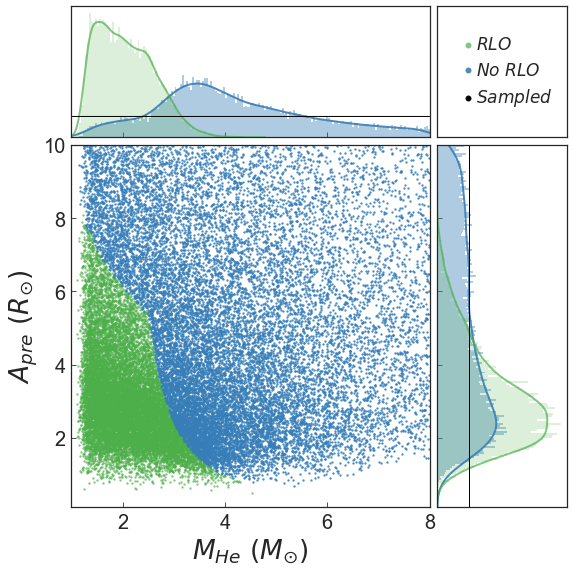

In [43]:
joint_pdf_v2(df, 'Mhe', 'Apre', ts=(1,14), save=True, kde=True, RLO_flag=True, vkick_flag=False)

### Supplementary figures

#### 5D corner plot

In [36]:
def big_corner(df, x, vary_param, vals, delta=None, valtype='min', kde=False, downsample=10000, \
               nbins=10, interval=0.9, save=False):

    fig = plt.figure(figsize=(10,8))
    gs = gridspec.GridSpec(3*len(x),2+3*len(x))
    sns.set_style("white")
    fs = 14   # font size
    ts = 11   # tick size
    
    # Set colormap
    cm = plt.get_cmap('viridis')
    if valtype == 'range':
        v_min, v_max = vals[0][0], vmax=vals[-1][0]
        cNorm  = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
    elif valtype == 'min':
        v_min, v_max = np.asarray(vals).min(), np.asarray(vals).max()
        cNorm  = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
    elif valtype == 'delta':
        v_min, v_max = np.asarray(vals).min(), np.asarray(vals).max()
        cNorm  = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
    
    # set up axes
    cbar_ax = fig.add_subplot(gs[:,:1])
    x0x4 = fig.add_subplot(gs[12:15,2:5])
    x0x3 = fig.add_subplot(gs[9:12,2:5])
    x0x2 = fig.add_subplot(gs[6:9,2:5])
    x0x1 = fig.add_subplot(gs[3:6,2:5])
    x1x4 = fig.add_subplot(gs[12:15,5:8])
    x1x3 = fig.add_subplot(gs[9:12,5:8])
    x1x2 = fig.add_subplot(gs[6:9,5:8])
    x2x4 = fig.add_subplot(gs[12:15,8:11])
    x2x3 = fig.add_subplot(gs[9:12,8:11])
    x3x4 = fig.add_subplot(gs[12:15,11:14])
    
    x0_marg = fig.add_subplot(gs[0:3,2:5])
    x1_marg = fig.add_subplot(gs[3:6,5:8])
    x2_marg = fig.add_subplot(gs[6:9,8:11])
    x3_marg = fig.add_subplot(gs[9:12,11:14])
    x4_marg = fig.add_subplot(gs[12:15,14:17])
    
    axs_1ds = [x0_marg, x1_marg, x2_marg, x3_marg, x4_marg]
    axs_1d_params = [x[0], x[1], x[2], x[3], x[4]]
    axs_2ds = [x0x1,x0x2,x0x3,x0x4,x1x2,x1x3,x1x4,x2x3,x2x4,x3x4]
    axs_2d_params = [(x[0],x[1]),(x[0],x[2]),(x[0],x[3]),(x[0],x[4]),(x[1],x[2]),(x[1],x[3]),(x[1],x[4]),\
                     (x[2],x[3]),(x[2],x[4]),(x[3],x[4])]

    
    # plot scatterplot of all points
    if len(df) > downsample: df_temp = df[:downsample]
    else: df_temp = df
    for ax, params in zip(axs_2ds, axs_2d_params):
        df_temp = df[:5000]
        ax.scatter(df_temp[params[0]],df_temp[params[1]], c='k', s=0.1, alpha=0.5, label=None, rasterized=True)
        
       
    # plot full marginalized histograms and 2D contours
    #ss = 10000 # for plotting initial samplings
    #for ax, param in zip(axs_1ds,axs_1d_params):
        #if param in samp_dict.keys():
        #    samps = np.linspace(lim_dict[param][0], lim_dict[param][1], ss)
        #    ax.plot(samps, samp_dict[param](samps), color='k', lw=1, label=None)
        # plot full range of values in black
        #bn = int(np.sqrt(len(df_temp)))
        #ax.hist(df_temp[param], color='k', normed=True, histtype='step', bins=bn, alpha=0.3, label=None)
        #if kde:
        #    sns.kdeplot(data=df_temp[param], ax=ax, gridsize=1000, color='k', lw=1)
        #    ax.legend_.remove()
     
    #for ax, params in zip(axs_2ds,axs_2d_params):
    #    if kde:
    #        h, xb, yb = np.histogram2d(df_temp[params[0]], df_temp[params[1]], bins=(20, 20), normed=True)
    #        dv = (xb[1] - xb[0]) * (yb[1] - yb[0])
    #        hf = h.flatten()
    #        hsort = hf.argsort()[::-1]
    #        idx = np.searchsorted(hf[hsort].cumsum() * dv, 0.9)
    #        x, y = np.meshgrid(xb[:-1], yb[:-1])
    #        thresh = hf[hsort][idx]
    #        sns.kdeplot(df_temp[params[0]], df_temp[params[1]], ax=ax, n_levels=[thresh], color='k')

     
    
    # LOOP OVER ALL CONSTRAINTS!
    for i, val in enumerate(vals):
        print '%s: %i' % (vary_param, val)
        
        if valtype=='range':
            df_temp = df[(df[vary_param] > val[0]) & (df[vary_param] < val[1])]
            cVal = scalarMap.to_rgba(val[0])
        elif valtype=='delta':
            df_temp = df[(df[vary_param] > val-delta) & (df[vary_param] < val+delta)]
            cVal = scalarMap.to_rgba(val)
        elif valtype=='min':
            df_temp = df[(df[vary_param] > val)]
            cVal = scalarMap.to_rgba(val)
            
        print 'nsamps: %i' % len(df_temp)
        if len(df_temp) > downsample: df_temp = df_temp[:downsample]
    
        for ax, param in zip(axs_1ds,axs_1d_params):
            # 1D marginalized histograms
            bn = int(np.sqrt(len(df_temp)))
            ax.hist(df_temp[param], color=cVal, normed=True, histtype='step', bins=bn, alpha=0.3, label=None)
            if kde: 
                sns.kdeplot(data=df_temp[param], ax=ax, gridsize=1000, color=cVal, lw=1)
                ax.legend_.remove()
                
        for ax, params in zip(axs_2ds,axs_2d_params):
            if kde:
                h, xb, yb = np.histogram2d(df_temp[params[0]], df_temp[params[1]], bins=(nbins, nbins), normed=True)
                dv = (xb[1] - xb[0]) * (yb[1] - yb[0])
                hf = h.flatten()
                hsort = hf.argsort()[::-1]
                idx = np.searchsorted(hf[hsort].cumsum() * dv, interval)
                thresh = hf[hsort][idx]
                sns.kdeplot(df_temp[params[0]], df_temp[params[1]], ax=ax, n_levels=[thresh], colors=[cVal], cmap=None, shade=False)
                
            
        
    # set up limits, labels, etc. 
    # marginalized
    for ax, param in zip(axs_1ds,axs_1d_params):
        if ax == x4_marg: 
            ax.set_xlabel(lbl_dict[param], fontsize=fs)
            ax.set_xticks(tick_dict[param])
            ax.tick_params(labelsize=ts, axis='x', which='major', direction='in', length=5)
            
        else:
            ax.set_xticks(tick_dict[param])
            ax.tick_params(axis='x', which='major', direction='in', length=5)
            ax.xaxis.set_ticklabels([])
            
        ax.yaxis.set_visible(False)
        ax.set_xlim(lim_dict[param])
        #ax.set_ylim(bottom=0)
        
        
    # 2DS
    for ax, param in zip(axs_2ds,axs_2d_params):
        ax.set_xlim(lim_dict[param[0]])
        ax.set_ylim(lim_dict[param[1]])  
        ax.set_xticks(tick_dict[param[0]])
        ax.set_yticks(tick_dict[param[1]])
        if ax == x0x3:
            ax.set_yticks([2.5,5.0,7.5,10.0])
        ax.tick_params(labelsize=ts, axis='both', which='major', direction='in', length=5)
        ax.set_xlabel(lbl_dict[param[0]], fontsize=fs)
        ax.set_ylabel(lbl_dict[param[1]], fontsize=fs)
        ax.get_yaxis().set_label_coords(-0.18,0.5)
        if ax not in [x0x4, x1x4, x2x4, x3x4]:
            ax.xaxis.set_ticklabels([]) 
            ax.set_xlabel('')
        if ax not in [x0x1, x0x2, x0x3, x0x4]:
            ax.yaxis.set_ticklabels([]) 
            ax.set_ylabel('')

          
                
    
    # make colorbar axis
    pts = x0x1.scatter([0],[0],c=[0], vmin=v_min, vmax=v_max, cmap='viridis', alpha=1, s=0.01)
    cbar = fig.colorbar(pts, cax=cbar_ax, ticks=[0,v_max], orientation='vertical')    
    cbar.set_label(lbl_dict[vary_param], fontsize=fs, labelpad=0)
    tick_locator = ticker.MaxNLocator(nbins=7)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=ts, axis='both', which='major', direction='out', length=5)
    cbar_ax.yaxis.set_ticks_position('left')
    cbar_ax.yaxis.set_label_position('left')

    gs.update(wspace=0.1, hspace=0.1)
    plt.subplots_adjust(left=0.08, bottom=0.07, right=0.98, top=0.97)

    # save fig
    if save==True:
        plt.savefig('corner_'+vary_param+'.pdf', format='pdf', dpi=100)



In [37]:
lim_dict={'Vkick': (0,1000), 'Mhe': (1,8), 'Apre': (0.1,10), 'Apost': (0.1,10), \
          'Apre_Apost': (0.5,2), 'R': (0.1,10), 'R_proj': (0,10), 'Rmerge': (2.2,10), 'Tmerge': (0,14)}

lbl_dict={'Vkick': '$V_{kick}\ (km/s)$', 'R': '$R_{SN}\ (kpc)$', 'R_proj': '$R_{SN,proj}\ (kpc)$', 'Mhe': '$M_{He}\ (M_{\odot})$', \
            'Apre': '$A_{pre}\ (R_{\odot})$', 'Apost': '$A_{post}\ (R_{\odot})$', \
          'Apre_Apost': '$A_{pre}/A_{post}$', 'Tmerge': '$T_{delay}\ (Gyr)$', \
          'Rmerge': '$R_{merger}\ (kpc)$',  'Rmerge_proj': '$R_{merger,proj}\ (kpc)$'}

tick_dict={'Vkick': [0,250,500,750,1000], 'R': [2.5,5,7.5], 'R_proj': '$R_{SN,proj}\ (kpc)$', \
           'Mhe': [2.0,4.0,6.0,8.0], 'Apre': [2.5,5,7.5,10], 'Apost': '$A_{post}\ (R_{\odot})$', \
          'Apre_Apost': '$A_{pre}/A_{post}$', 'Tmerge': '$T_{delay}\ (Gyr)$', \
          'Rmerge': [2.5,5,7.5,10],  'Rmerge_proj': '$R_{merger,proj}\ (kpc)$'}

Tmerge: 0
nsamps: 138870
Tmerge: 1
nsamps: 34006
Tmerge: 2
nsamps: 26325
Tmerge: 4
nsamps: 17709
Tmerge: 6
nsamps: 12151
Tmerge: 8
nsamps: 8142
Tmerge: 10
nsamps: 4936
Tmerge: 12
nsamps: 2268


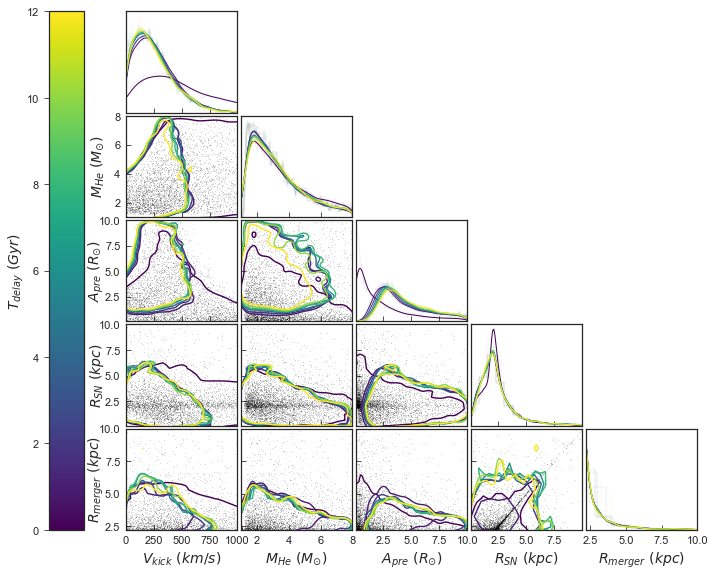

In [38]:
df_temp = df[df.flag == 1]


# possible valtypes: mins (use val as minimum bound), delta (only select systems +- delta from the value\
# or range (specify the ranges with tuples))
big_corner(df_temp, ['Vkick','Mhe','Apre','R','Rmerge'], 'Tmerge', [0,1,2,4,6,8,10,12], \
              delta=0.2, valtype='min', kde=True, downsample=10000, nbins=30, interval=0.9, save=True)


In [445]:
df_temp_13 = df[(df.flag==1) & (df.Tmerge>13) & (df.Vkick > 300)]
df_temp = df[(df.flag==1)]

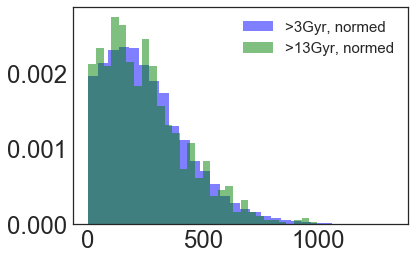

In [444]:
_,_,_ = plt.hist(df_temp_3.Vkick, bins=30, color='b', alpha=0.5, normed=True, label='>3Gyr, normed')
_,_,_ = plt.hist(df_temp_13.Vkick, bins=30, color='g', alpha=0.5, normed=True, label='>13Gyr, normed')
plt.legend(prop={'size':15})

#### 2D contour plot

In [76]:
def contour_plot(df, x_str, vary_param, vals, delta=None, valtype='min', kde=False, downsample=10000, save=False):

    fig = plt.figure(figsize=(10,8))
    gs = gridspec.GridSpec(7,10)
    sns.set_style("white")
    fs = 25   # font size
    ts = 20   # tick size
    ds = 10000   # downsample
    
    # Set colormap
    cm = plt.get_cmap('viridis')
    if valtype == 'range':
        v_min, v_max = vals[0][0], vmax=vals[-1][0]
        cNorm  = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
    elif valtype == 'min':
        v_min, v_max = np.asarray(vals).min(), np.asarray(vals).max()
        cNorm  = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
    elif valtype == 'delta':
        v_min, v_max = np.asarray(vals).min(), np.asarray(vals).max()
        cNorm  = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
    
    # set up axes
    cbar_ax = fig.add_subplot(gs[:,:1])
    x0_marg = fig.add_subplot(gs[0:2,3:8])
    x1_marg = fig.add_subplot(gs[2:7,8:10])
    x0x1 = fig.add_subplot(gs[2:7,3:8])
    
    axs_1ds = [x0_marg, x1_marg]
    axs_1d_params = [x_str[0], x_str[1]]
    axs_2ds = [x0x1]
    axs_2d_params = [(x_str[0],x_str[1])]
    

    
    # plot scatterplot of all points
    if len(df) > ds: df_temp = df[:ds]
    else: df_temp = df
    for ax, params in zip(axs_2ds, axs_2d_params):
        ax.scatter(df_temp[params[0]],df_temp[params[1]], c='k', s=0.1, alpha=0.5, label=None, rasterized=True)
        
    # plot full marginalized histograms and 2D contours
    #ss = 10000 # for plotting initial samplings
    #for ax, param in zip(axs_1ds,axs_1d_params):
        #if param in samp_dict.keys():
        #    samps = np.linspace(lim_dict[param][0], lim_dict[param][1], ss)
        #    ax.plot(samps, samp_dict[param](samps), color='k', lw=1, label=None)
        # plot full range of values in black
        #bn = int(np.sqrt(len(df_temp)))
        #if ax == x0_marg: 
        #    ax.hist(df_temp[param], color='k', normed=True, histtype='step', \
        #            bins=bn, alpha=0.3, label=None)
        #    if kde:
        #        sns.kdeplot(data=df_temp[param], ax=ax, gridsize=1000, color='k', lw=1)
        #        ax.legend_.remove() 
        #if ax == x1_marg: 
        #    ax.hist(df_temp[param], color='k', normed=True, histtype='step', orientation='horizontal', \
        #            bins=bn, alpha=0.3, label=None)
        #    if kde:
        #        sns.kdeplot(data=df_temp[param], ax=ax, gridsize=1000, vertical=True, color='k', lw=1)
        #        ax.legend_.remove()
     
    #for ax, params in zip(axs_2ds,axs_2d_params):
    #    if kde:
    #        h, xb, yb = np.histogram2d(df_temp[params[0]], df_temp[params[1]], bins=(20, 20), normed=True)
    #        dv = (xb[1] - xb[0]) * (yb[1] - yb[0])
    #        hf = h.flatten()
    #        hsort = hf.argsort()[::-1]
    #        idx = np.searchsorted(hf[hsort].cumsum() * dv, 0.9)
    #        x, y = np.meshgrid(xb[:-1], yb[:-1])
    #        thresh = hf[hsort][idx]
    #        sns.kdeplot(df_temp[params[0]], df_temp[params[1]], ax=ax, n_levels=[thresh], color='k')

     
    
    # LOOP OVER ALL CONSTRAINTS!
    for i, val in enumerate(vals):
        print '%s: %i' % (vary_param, val)
        
        if valtype=='range':
            df_temp = df[(df[vary_param] > val[0]) & (df[vary_param] < val[1])]
            cVal = scalarMap.to_rgba(val[0])
        elif valtype=='delta':
            df_temp = df[(df[vary_param] > val-delta) & (df[vary_param] < val+delta)]
            cVal = scalarMap.to_rgba(val)
        elif valtype=='min':
            df_temp = df[(df[vary_param] > val)]
            cVal = scalarMap.to_rgba(val)
            
        print 'nsamps: %i' % len(df_temp)
        if len(df_temp) > downsample: df_temp = df_temp[:downsample]
    
        for ax, param in zip(axs_1ds,axs_1d_params):
            # 1D marginalized histograms
            bn = int(np.sqrt(len(df_temp)))
            if ax == x0_marg:
                ax.hist(df_temp[param], color=cVal, normed=True, histtype='step', bins=bn, alpha=0.3, label=None)
                if kde: 
                    sns.kdeplot(data=df_temp[param], ax=ax, gridsize=1000, color=cVal, lw=1)
                    ax.legend_.remove()
            if ax == x1_marg:
                ax.hist(df_temp[param], color=cVal, normed=True, histtype='step', orientation='horizontal', bins=bn, alpha=0.3, label=None)
                if kde: 
                    sns.kdeplot(data=df_temp[param], ax=ax, gridsize=1000, vertical='True', color=cVal, lw=1)
                    ax.legend_.remove()
                
        for ax, params in zip(axs_2ds,axs_2d_params):
            if kde:
                h, xb, yb = np.histogram2d(df_temp[params[0]], df_temp[params[1]], bins=(10, 10), normed=True)
                dv = (xb[1] - xb[0]) * (yb[1] - yb[0])
                hf = h.flatten()
                hsort = hf.argsort()[::-1]
                idx = np.searchsorted(hf[hsort].cumsum() * dv, 0.9)
                thresh = hf[hsort][idx]
                sns.kdeplot(df_temp[params[0]], df_temp[params[1]], ax=ax, n_levels=[thresh], colors=[cVal], cmap=None, shade=False)
                
    # make colorbar axis
    pts = x0x1.scatter([0],[0],c=[0], vmin=v_min, vmax=v_max, cmap='viridis', alpha=1, s=0.01)
    cbar = fig.colorbar(pts, cax=cbar_ax, ticks=[0,v_max], orientation='vertical')    
    cbar.set_label(lbl_dict[vary_param], fontsize=fs, labelpad=-10)
    cbar.ax.tick_params(labelsize=ts)
    cbar_ax.yaxis.set_ticks_position('left')
    cbar_ax.yaxis.set_label_position('left')
    
    # set up limits, labels, etc. 
    # marginalized
    for ax, param in zip(axs_1ds,axs_1d_params):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        if ax == x0_marg:
            ax.set_xlim(lim_dict[param])
        if ax == x1_marg:
            ax.set_ylim(lim_dict[param])
        
    # 2DS
    for ax, param in zip(axs_2ds,axs_2d_params):
        x0x1.set_xlabel(lbl_dict[param[0]], fontsize=fs)
        x0x1.set_ylabel(lbl_dict[param[1]], fontsize=fs)  
        x0x1.set_xlim(lim_dict[param[0]])
        x0x1.set_ylim(lim_dict[param[1]])

    gs.update(wspace=0.1, hspace=0.1)
    plt.subplots_adjust(left=0.09, bottom=0.1, right=0.97, top=.97)

    # save fig
    if save==True:
        plt.savefig('countour2D_'+x_str[0]+'_'+x_str[1]+'_'+run+'_'+valtype+'.png', format='png', dpi=250)



Tmerge: 0
nsamps: 3509345
Tmerge: 1
nsamps: 982700
Tmerge: 2
nsamps: 737683
Tmerge: 5
nsamps: 398943
Tmerge: 8
nsamps: 218794
Tmerge: 10
nsamps: 132187


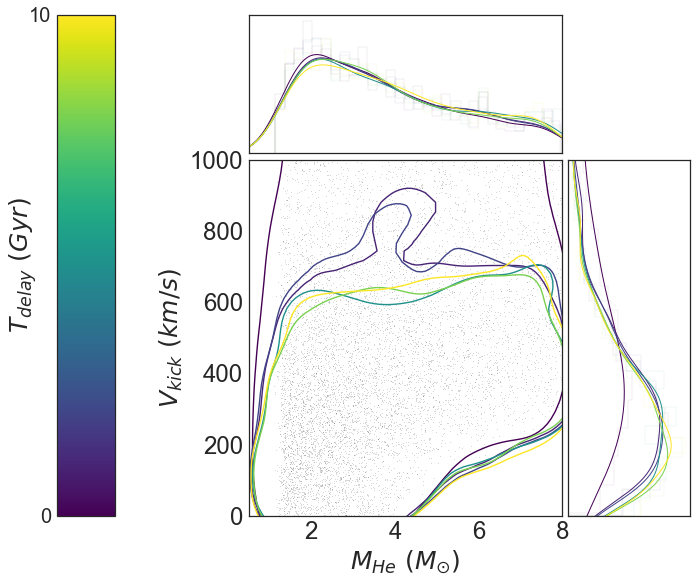

In [77]:
df_temp = df[df.flag == 1]


# possible valtypes: mins (use val as minimum bound), delta (only select systems +- delta from the value\
# or range (specify the ranges with tuples))
contour_plot(df, ['Mhe','Vkick'], 'Tmerge', [0,1,2,5,8,10], \
              delta=0.1, valtype='min', kde=True, downsample=1000, save=True)